In [1]:
# !pip install medmnist

In [2]:
# https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb

In [3]:
%load_ext autoreload
%autoreload 1

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import medmnist
from medmnist import INFO, Evaluator
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision
import torch.nn.functional as F

from tqdm import tqdm

# %aimport basic_vae
# %aimport utils
from utils import plot_real_vs_constructed 
from utils import load_dataset
from utils import plot_generated
from utils import modify_latent
from utils import generate_gif
# from basic_vae import VariationalAutoencoder

/home/ruben/anaconda3/envs/cv1/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# data_flag = 'pathmnist'
data_flag = 'bloodmnist'
# data_flag = 'organamnist'
train_dataset, test_dataset, train_loader,_, _ = load_dataset(data_flag, 64, True)
# data_flag = 'organcmnist'
# train_dataset_2, test_dataset_2, train_loader_2,_, _ = load_dataset(data_flag, 64, True)
# data_flag = 'organsmnist'
# train_dataset_3, test_dataset_3, train_loader_3,_, _ = load_dataset(data_flag, 64, True)

# train_dataset = torch.utils.data.ConcatDataset([train_dataset, train_dataset_2, train_dataset_3])
# test_dataset = torch.utils.data.ConcatDataset([test_dataset, test_dataset_2, test_dataset_2])
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)


Using downloaded and verified file: /home/ruben/.medmnist/bloodmnist.npz
Using downloaded and verified file: /home/ruben/.medmnist/bloodmnist.npz
Using downloaded and verified file: /home/ruben/.medmnist/bloodmnist.npz


In [6]:
from beta_conv_vae import VariationalAutoencoder
# from basic_vae import VariationalAutoencoder

latent_dims = 128 #hyperparameter we can optimze?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vae = VariationalAutoencoder(latent_dims, mode="beta_vae", channels=3).to(device) # GPU

# vae.train(train_loader, lr=0.001, epochs=2, device=device)
# vae.train(train_loader, lr=0.0001, epochs=10, device=device)
# plot_latent(vae, train_loader)

In [7]:
# vae.train(train_loader, lr=0.000001, epochs=5, device=device)
# vae.train(train_loader, lr=0.001, epochs=50, device=device)
# vae.train(train_loader, lr=0.0001, epochs=30, device=device)
# vae.train(train_loader, lr=0.00001, epochs=20, device=device)

In [8]:
# vae.save_to_file(path="./path_beta_v2")

In [10]:
vae.load_from_file(path="./blood_beta_v6")
_ = plot_real_vs_constructed(vae, test_dataset, device)

FileNotFoundError: [Errno 2] No such file or directory: './blood_beta_v6'

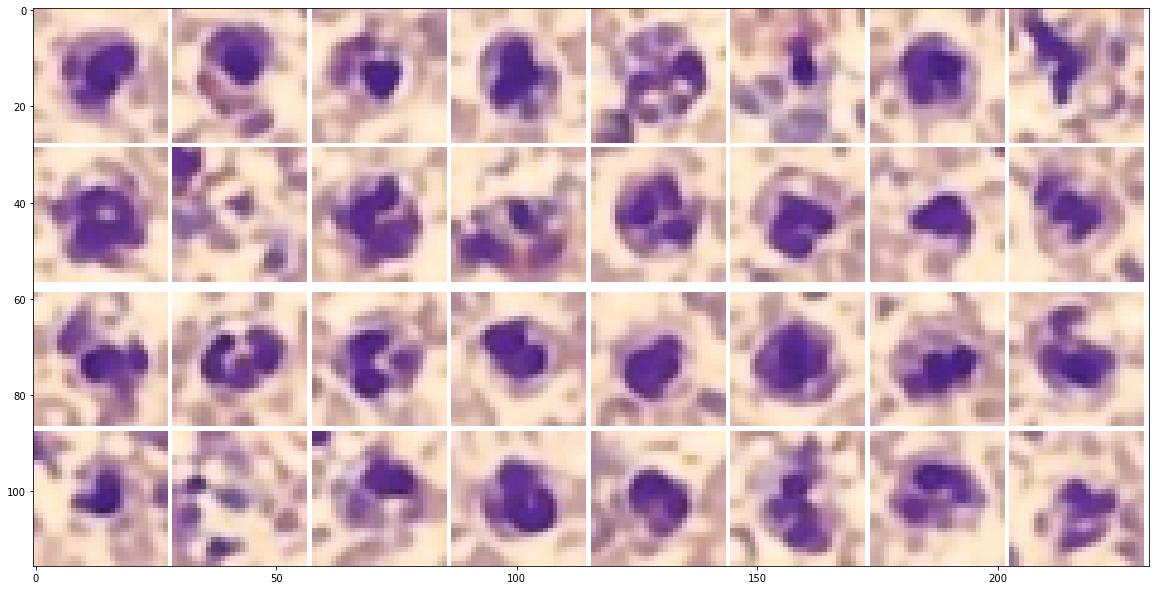

In [ ]:
_ = plot_generated(vae, device)

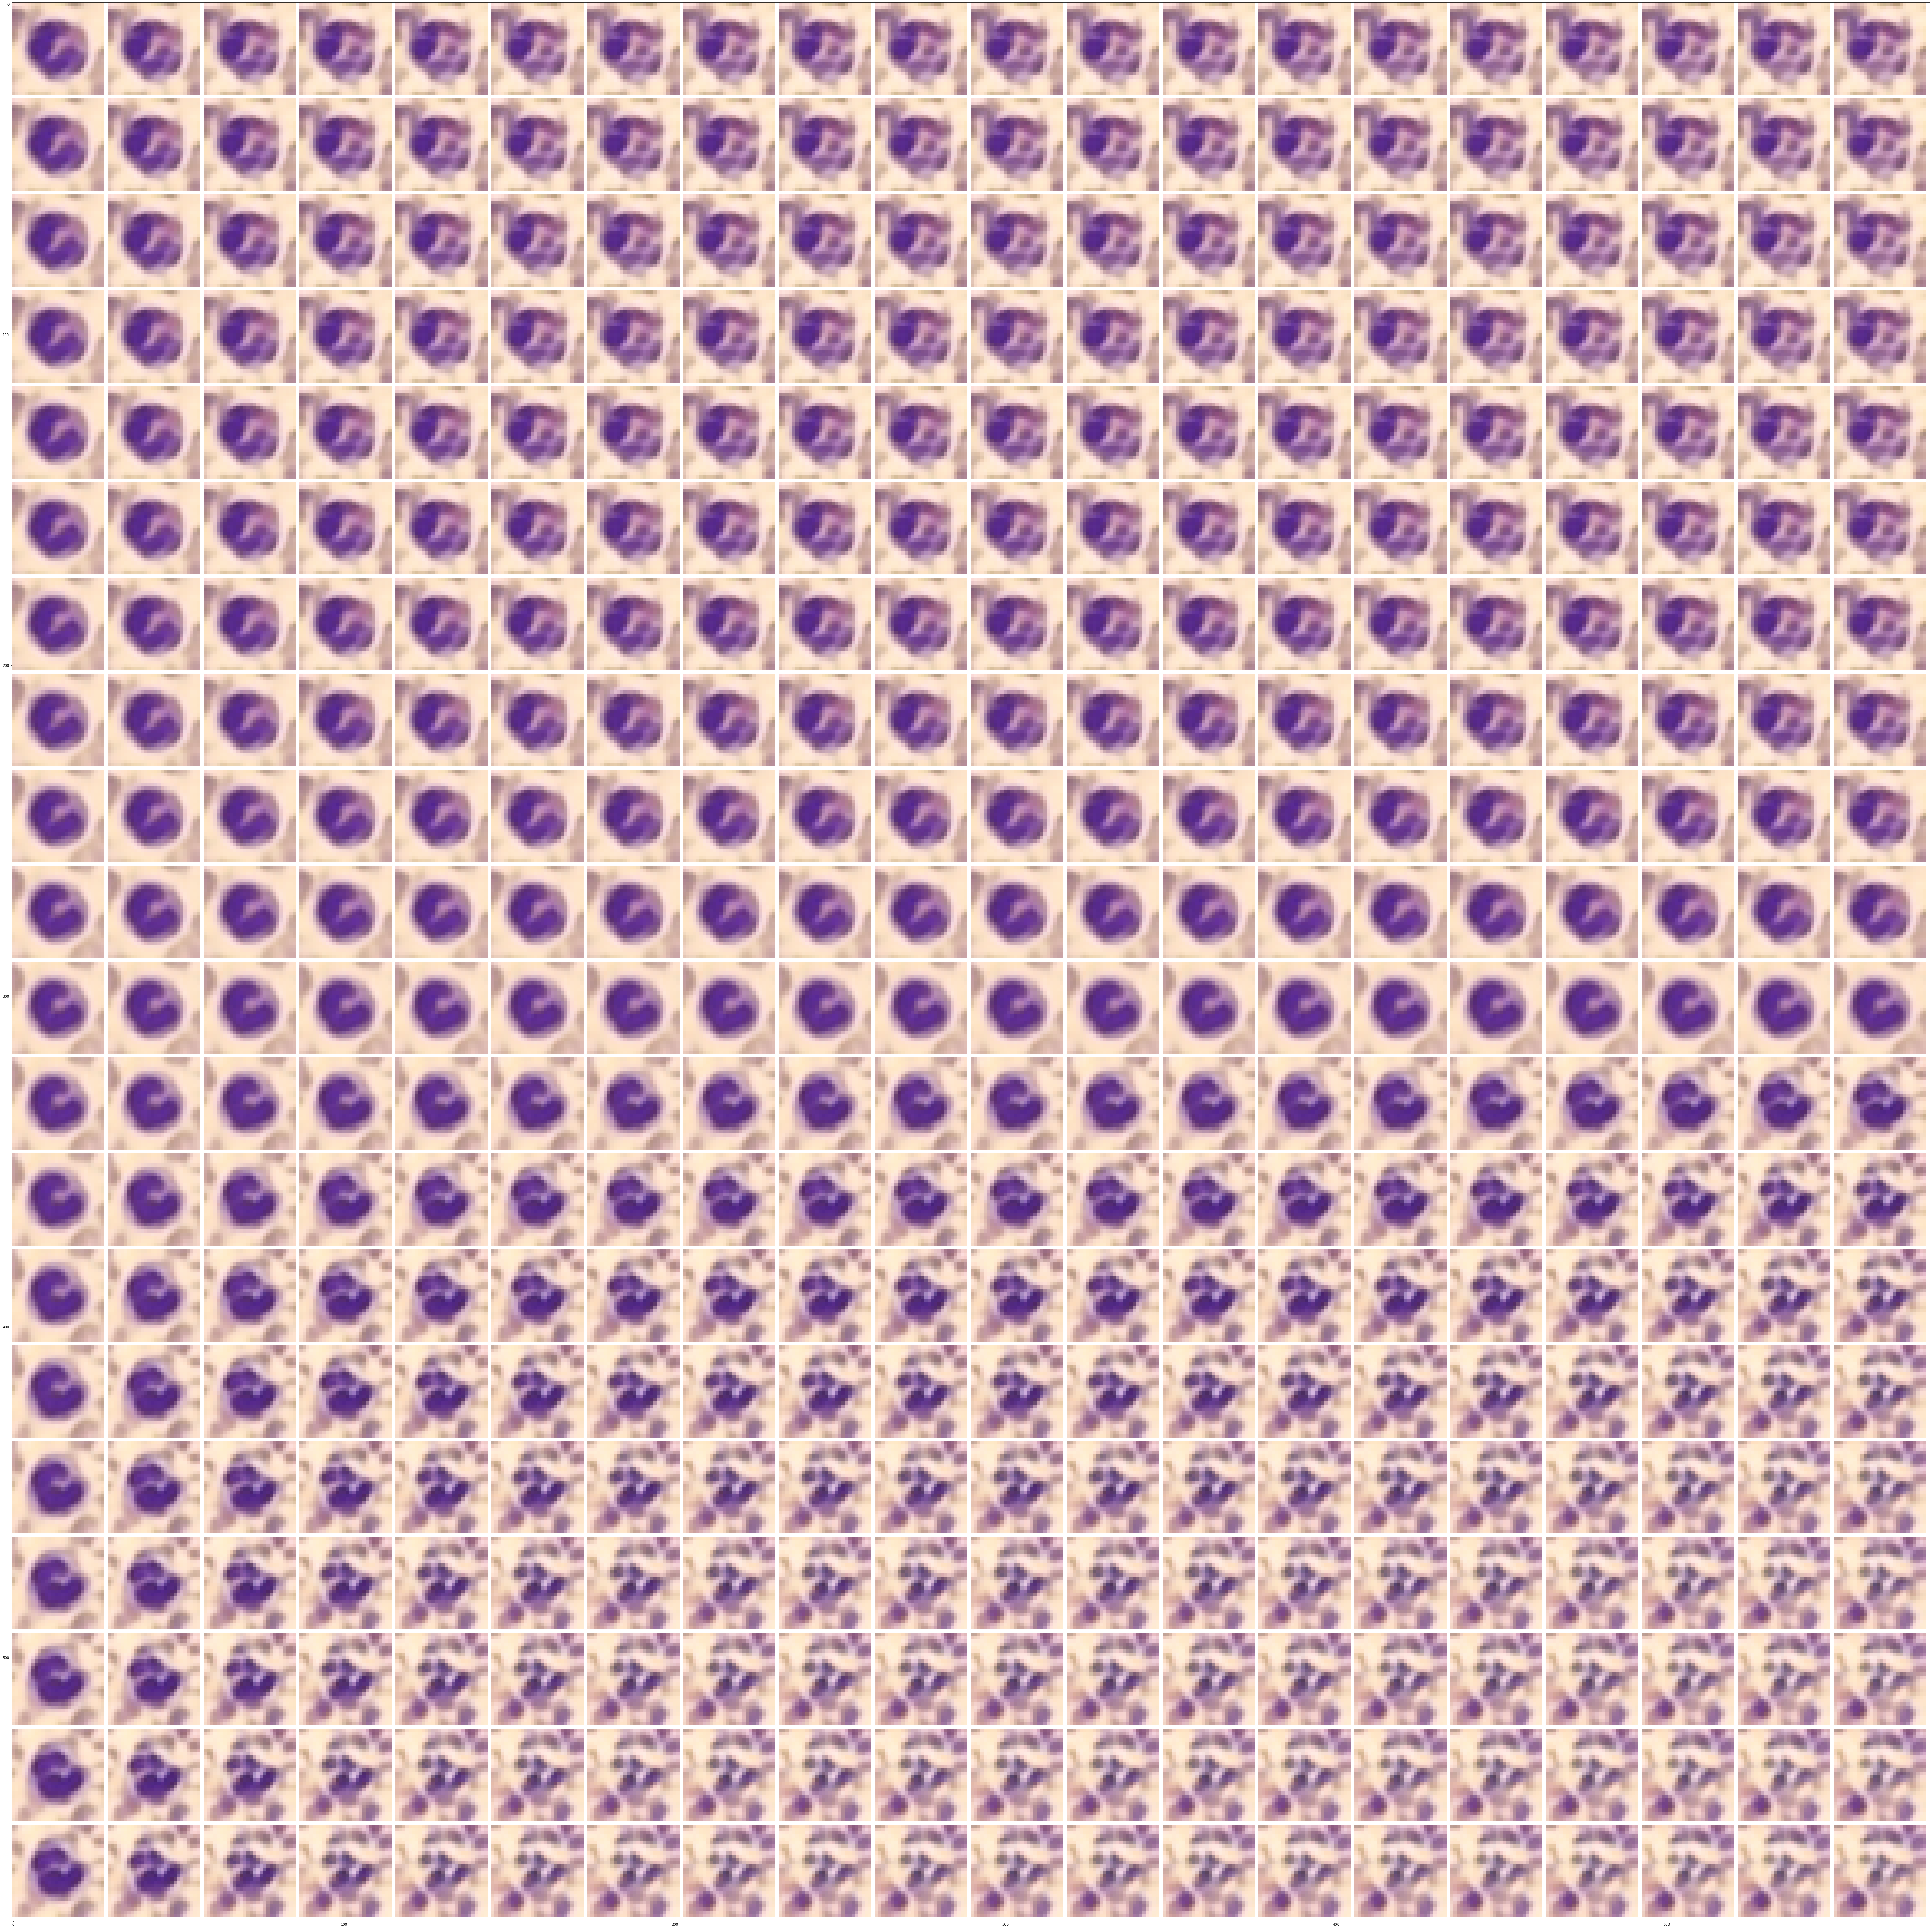

In [ ]:
_ = modify_latent(vae, test_dataset, img_nr=8, device=device)

In [ ]:
from IPython.display import display, HTML
t = generate_gif(vae, test_dataset, img_nr=8, device=device)

HTML(f'''
<img height="300" id="picture" src="data:image/gif;base64,{t}">
''')

# New Section

In [ ]:
i = torch.randn((3, 28, 28))
cov1 = nn.Conv2d(3, 12, 3, stride=2)
cov2 = nn.Conv2d(12, 24, 3, stride=2)
cov2_5 = nn.Conv2d(24, 48, 3, stride=2)
m1 = nn.MaxPool2d(2)
m2 = nn.MaxUnpool2d(3)
lin1 = nn.Linear(192,192)
cov3 = nn.ConvTranspose2d(48,24,3, stride=2)#, output_padding=1)
cov4 = nn.ConvTranspose2d(24,12,4, stride=2)#, output_padding=1)
cov5 = nn.ConvTranspose2d(12,4,4, stride=2)#, output_padding=1)
cov6 = nn.ConvTranspose2d(4,3,3, stride=2)#, output_padding=1)
cov7 = nn.Conv2d(3,3,1, stride=2, padding=1)#, output_padding=1)
print(i.flatten().shape, i.shape)
x = cov1(i)
x = cov2(x)
x = cov2_5(x)
# x = m1(x)
print(x.flatten().shape, x.shape)
x = lin1(x.flatten())
x = x.reshape(48,2,2)
x = cov3(x)
x = cov4(x)
# x = cov4_5(x)
x = cov5(x)
x = cov6(x)
x = cov7(x)
# x = m2(x)
print(x.flatten().shape, x.shape)


torch.Size([2352]) torch.Size([3, 28, 28])
torch.Size([192]) torch.Size([48, 2, 2])
torch.Size([2352]) torch.Size([3, 28, 28])


In [ ]:
tmp = torch.randn((1, 1, 28, 28))
modules = []
hidden_dims = [32, 64, 128, 256] # 512
# hidden_dims = [28, 56, 112, 224]
# hidden_dims = [28, 56, 112]

in_channels = 1
for h_dim in hidden_dims:
    modules.append(
        nn.Sequential(
            nn.Conv2d(in_channels, out_channels=h_dim,
                        kernel_size= 3, stride= 2, padding  = 1),
            nn.BatchNorm2d(h_dim),
            nn.LeakyReLU())
    )
    in_channels = h_dim
encoder = nn.Sequential(*modules)

hidden_dims.reverse()
modules = []
for i in range(len(hidden_dims) - 1):
    modules.append(
        nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[i],
                                hidden_dims[i + 1],
                                kernel_size=3,
                                stride = 2,
                                padding=1,
                                output_padding=1),
            nn.BatchNorm2d(hidden_dims[i + 1]),
            nn.LeakyReLU())
    )
decoder = nn.Sequential(*modules)

final_layer = nn.Sequential(
    nn.ConvTranspose2d(hidden_dims[-1],
                        hidden_dims[-1],
                        kernel_size=2,
                        stride=2,
                        padding=1),
    nn.BatchNorm2d(hidden_dims[-1]),
    nn.LeakyReLU(),
    nn.Conv2d(hidden_dims[-1], out_channels= 1,
                kernel_size= 3),
    nn.Tanh())

print(tmp.flatten().shape, tmp.shape)
x = encoder(tmp)
print(x.flatten().shape, x.shape)
print(torch.flatten(x, start_dim=1).shape)
x = decoder(x)
x = final_layer(x)
print(x.flatten().shape, x.shape)

torch.Size([784]) torch.Size([1, 1, 28, 28])
torch.Size([1024]) torch.Size([1, 256, 2, 2])
torch.Size([1, 1024])
torch.Size([784]) torch.Size([1, 1, 28, 28])
